### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
ls /mnt/share/costeffectiveness/results/vivarium_nih_us_cvd/model_2/v1_ldl_c/alabama/2022_08_18_16_54_20/

__pycache__/   keyspace.yaml             output.hdf
branches.yaml  logs/                     requirements.txt
count_data/    model_specification.yaml  settings.py


In [3]:
ls /mnt/share/costeffectiveness/results/vivarium_nih_us_cvd/model_2/v1_ldl_c/alabama/2022_08_18_16_54_20/count_data

deaths.csv              population.csv         transition_count.csv  ylls.csv
deaths.hdf              population.hdf         transition_count.hdf  ylls.hdf
ldlc_exposure_time.csv  state_person_time.csv  ylds.csv
ldlc_exposure_time.hdf  state_person_time.hdf  ylds.hdf


In [4]:
sim_results_dir = '/mnt/share/costeffectiveness/results/vivarium_nih_us_cvd/model_2/v1_ldl_c/alabama/2022_08_18_16_54_20/count_data/'

### Exploring Data

In [5]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,female,2023,acute_ischemic_stroke,deaths,29,baseline,25_to_29,0
1,1,female,2023,acute_ischemic_stroke,deaths,29,baseline,30_to_34,0
2,2,female,2023,acute_ischemic_stroke,deaths,29,baseline,35_to_39,0
3,3,female,2023,acute_ischemic_stroke,deaths,29,baseline,40_to_44,0
4,4,female,2023,acute_ischemic_stroke,deaths,29,baseline,45_to_49,0


In [6]:
pop = pd.read_csv(sim_results_dir + 'population.csv')
pop.loc[pop.measure=="total_population_untracked"].value.sum()
pop.head()

,Unnamed: 0,measure,input_draw,scenario,value
0,0,total_population,29,baseline,750000
1,1,total_population,232,baseline,750000
2,2,total_population,357,baseline,750000
3,3,total_population,394,baseline,750000
4,4,total_population,602,baseline,750000


In [7]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
tran.transition.unique()

array(['ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [8]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

102898190.44490075

In [9]:
person_time_test = state_person_time.loc[state_person_time['state'].isin(["myocardial_infarction_acute_myocardial_infarction", "myocardial_infarction_post_myocardial_infarction", "myocardial_infarction_susceptible_to_myocardial_infarction"])].reset_index() 
person_time_test.value.sum()

102898190.44490075

### Total DALYs by Year

In [10]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

,sex,age,input_draw,year,yll,yld,daly
0,female,25_to_29,29,2023,1972.340513,29.882356,2002.222869
1,female,25_to_29,29,2024,2265.914729,28.464315,2294.379044
2,female,25_to_29,29,2025,1289.531647,28.069359,1317.601005
3,female,25_to_29,29,2026,1289.313714,26.829516,1316.143230
4,female,25_to_29,29,2027,1848.123203,25.954760,1874.077964


In [11]:
daly_sum = (daly_total
                .groupby(['year'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

,year,mean,2.5%,97.5%
0,2023,6216.160691,611.288298,13558.800515
1,2024,5866.899221,654.187464,12669.923537
2,2025,5937.122414,777.371689,12795.782256
3,2026,6013.541155,767.672490,13083.215046
4,2027,6064.934671,872.127416,13022.820665


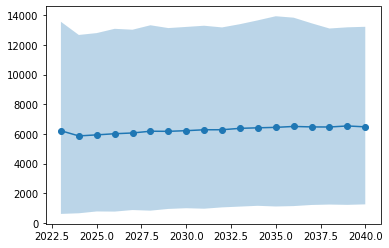

In [12]:
plt.plot(daly_sum['year'], daly_sum['mean'], marker = 'o')
plt.fill_between(daly_sum['year'], daly_sum['2.5%'], daly_sum['97.5%'], alpha = 0.3)

### All Cause Mortality Graphs

In [13]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,6.80,0.0,34.000
1,25_to_29,female,2024,5.70,0.0,26.550
2,25_to_29,female,2025,5.88,0.0,28.775
3,25_to_29,female,2026,5.30,0.0,30.100
4,25_to_29,female,2027,6.26,0.0,29.775


In [14]:
%%capture 
from matplotlib.backends.backend_pdf import PdfPages # PDF package

with PdfPages('model1vv_v2_raw_mortality_counts.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure()             
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Raw death counts: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=1000)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### All Cause Mortality Graph with Rate

In [15]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,female,2023,29,29970.157426
1,25_to_29,female,2023,232,30069.355236
2,25_to_29,female,2023,357,30064.985626
3,25_to_29,female,2023,394,30342.417522
4,25_to_29,female,2023,602,30300.944559


In [16]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.001127,0.000923,0.001348
1,25_to_29,female,2024,0.001024,0.000674,0.001293
2,25_to_29,female,2025,0.001066,0.000822,0.001267
3,25_to_29,female,2026,0.000973,0.000544,0.001356
4,25_to_29,female,2027,0.001163,0.000788,0.001452


In [17]:
%%capture 
with PdfPages('model1vv_v2_acmr.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'ACMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.4)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [18]:
%%capture 
## Has age and year reversed, so looking at year trend by age group now. 
with PdfPages('model1vv_v2_acmr_by_year.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for age in result_summary.age.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'ACMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymin=0) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Cause Specific Mortality Graphs
#### Acute Stroke

In [19]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,mean,2.5%,97.5%
0,0,25_to_29,female,2023,acute_ischemic_stroke,0.1,0.0,0.775
1,5,25_to_29,female,2024,acute_ischemic_stroke,0.2,0.0,1.000
2,10,25_to_29,female,2025,acute_ischemic_stroke,0.0,0.0,0.000
3,15,25_to_29,female,2026,acute_ischemic_stroke,0.0,0.0,0.000
4,20,25_to_29,female,2027,acute_ischemic_stroke,0.1,0.0,0.775


In [20]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,value
0,0,25_to_29,female,2023,29,acute_ischemic_stroke,0
1,5,25_to_29,female,2023,232,acute_ischemic_stroke,0
2,10,25_to_29,female,2023,357,acute_ischemic_stroke,0
3,15,25_to_29,female,2023,394,acute_ischemic_stroke,0
4,20,25_to_29,female,2023,602,acute_ischemic_stroke,0


In [21]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000003,0.0,0.000026
1,25_to_29,female,2024,0.000007,0.0,0.000036
2,25_to_29,female,2025,0.000000,0.0,0.000000
3,25_to_29,female,2026,0.000000,0.0,0.000000
4,25_to_29,female,2027,0.000004,0.0,0.000029


In [22]:
%%capture 
with PdfPages('model1vv_v2_acute_csmr.pdf') as pdf:
    for sex in acute_rate_summary.sex.unique():
        for year in acute_rate_summary.year.unique():
            plt.figure() 
            subdata = acute_rate_summary.loc[(acute_rate_summary.sex==sex) & (acute_rate_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Chronic Stroke

In [23]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000000,0.000000,0.000000
1,25_to_29,female,2024,0.000000,0.000000,0.000000
2,25_to_29,female,2025,0.000000,0.000000,0.000000
3,25_to_29,female,2026,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
536,95_plus,male,2037,0.008009,0.001655,0.012625
537,95_plus,male,2038,0.009595,0.005813,0.015200
538,95_plus,male,2039,0.009814,0.005943,0.012167
539,95_plus,male,2040,0.009428,0.004157,0.017173


In [24]:
%%capture
with PdfPages('model1vv_v2_chronic_csmr.pdf') as pdf:
    for sex in chronic_rate_summ.sex.unique():
        for year in chronic_rate_summ.year.unique():
            plt.figure() 
            subdata = chronic_rate_summ.loc[(chronic_rate_summ.sex==sex) & (chronic_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Chronic Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Acute Myocardial Infarction

In [25]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'chronic_ischemic_stroke', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [26]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_rate = pd.concat([acute_MI_rate, per_time_group.ptvalue], axis=1)
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000109,0.000033,0.000269
1,25_to_29,female,2024,0.000130,0.000044,0.000254
2,25_to_29,female,2025,0.000087,0.000036,0.000145
3,25_to_29,female,2026,0.000059,0.000008,0.000168
4,25_to_29,female,2027,0.000126,0.000046,0.000292


In [27]:
%%capture
with PdfPages('model1vv_v2_acute_MI_csmr.pdf') as pdf:
    for sex in acute_MI_rate_summ.sex.unique():
        for year in acute_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = acute_MI_rate_summ.loc[(acute_MI_rate_summ.sex==sex) & (acute_MI_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Post Myocaridal Infarction

In [28]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000050,0.000000,0.000100
1,25_to_29,female,2024,0.000065,0.000000,0.000191
2,25_to_29,female,2025,0.000069,0.000008,0.000173
3,25_to_29,female,2026,0.000051,0.000000,0.000130
4,25_to_29,female,2027,0.000074,0.000037,0.000112


In [29]:
%%capture
with PdfPages('model1vv_v2_post_MI_csmr.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for year in post_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [30]:
%%capture
with PdfPages('model1vv_v2_post_MI_csmr_byyear.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for age in post_MI_rate_summ.age.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI CSMR by Year: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Excess Mortality rate

#### Post Ischemic Stroke

In [31]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.039318,0.000000,0.077408
1,25_to_29,female,2024,0.046358,0.000000,0.129489
2,25_to_29,female,2025,0.046090,0.005260,0.108525
3,25_to_29,female,2026,0.035123,0.000000,0.095338
4,25_to_29,female,2027,0.050798,0.025187,0.078700


In [32]:
%%capture
with PdfPages('model1vv_v2_post_MI_emr.pdf') as pdf:
    for sex in post_MI_emr_summ.sex.unique():
        for year in post_MI_emr_summ.year.unique():
            plt.figure() 
            subdata = post_MI_emr_summ.loc[(post_MI_emr_summ.sex==sex) & (post_MI_emr_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI EMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Prevalence 

#### Chronic + Acute Stroke

In [33]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000009,2.528880e-06,0.000025
1,25_to_29,female,2024,0.000013,5.472550e-06,0.000033
2,25_to_29,female,2025,0.000009,6.174669e-07,0.000025
3,25_to_29,female,2026,0.000008,6.322427e-07,0.000017
4,25_to_29,female,2027,0.000007,0.000000e+00,0.000027


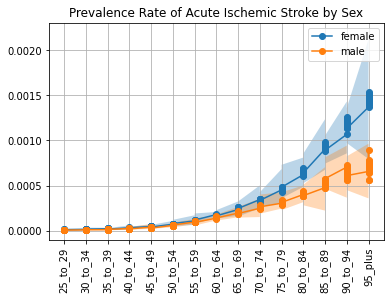

In [34]:
groups = prev_acute_rate_sum.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Acute Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [35]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

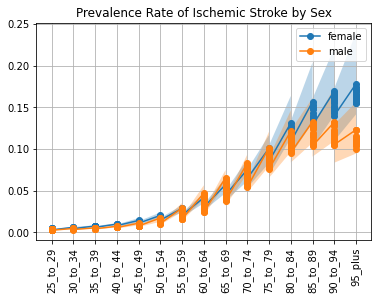

In [36]:
groups = prev_chronic_rate_sum.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

#### Myocardial Infarction

In [37]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_acute_myocardial_infarction')].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = pd.concat([prev_acute_MI, per_time_group.ptvalue], axis=1)
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000038,0.000020,0.000056
1,25_to_29,female,2024,0.000035,0.000020,0.000059
2,25_to_29,female,2025,0.000036,0.000017,0.000068
3,25_to_29,female,2026,0.000033,0.000013,0.000059
4,25_to_29,female,2027,0.000038,0.000018,0.000059


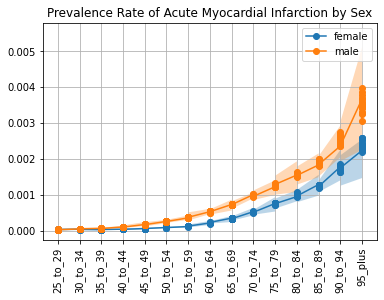

In [38]:
groups = prev_acute_MI_summ.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Acute Myocardial Infarction by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [39]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.001355,0.000911,0.001668
1,25_to_29,female,2024,0.001445,0.001108,0.001616
2,25_to_29,female,2025,0.001485,0.001194,0.001721
3,25_to_29,female,2026,0.001477,0.001218,0.001754
4,25_to_29,female,2027,0.001463,0.001204,0.001692


In [40]:
%%capture
for sex in prev_post_MI_summ.sex.unique():
    for year in prev_post_MI_summ.year.unique():
        plt.figure() 
        subdata = prev_post_MI_summ.loc[(post_MI_rate_summ.sex==sex) & (prev_post_MI_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Post MI Prevalence: {year} {sex}') 
        plt.xticks(rotation=90) 
        plt.ylim(ymax=0.05)
        plt.grid()

### Incidence of First Time Acute Ischemic Stroke

In [41]:
tran.transition.unique()

array(['ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [42]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,mean,2.5%,97.5%
0,2,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,3.4,1.000,9.650
1,8,25_to_29,female,2024,ischemic_stroke_susceptible_to_ischemic_stroke...,5.1,2.000,11.100
2,14,25_to_29,female,2025,ischemic_stroke_susceptible_to_ischemic_stroke...,3.1,0.225,9.650
3,20,25_to_29,female,2026,ischemic_stroke_susceptible_to_ischemic_stroke...,2.8,0.225,6.000
4,26,25_to_29,female,2027,ischemic_stroke_susceptible_to_ischemic_stroke...,3.0,0.000,10.325


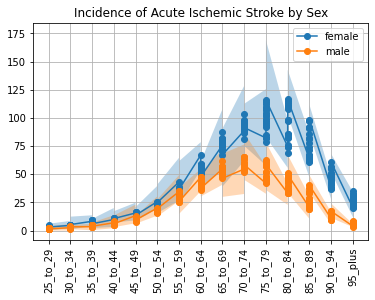

In [43]:
groups = tran_sum_stroke.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Incidence of Acute Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [44]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,ptvalue
0,20,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,29809.325120
1,21,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,232,29918.565366
2,22,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,357,29908.062971
3,23,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,394,30172.462697
4,24,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,602,30129.149897


In [45]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000252,0.0,0.000539
1,25_to_29,female,2025,0.000075,0.0,0.000303
2,25_to_29,female,2026,0.000247,0.0,0.000598
3,25_to_29,female,2028,0.000062,0.0,0.000235
4,25_to_29,female,2029,0.000273,0.0,0.000784


In [46]:
%%capture
with PdfPages('model1vv_v2_acute_stroke_inc.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
        for age in tran_rate_sum.age.unique():
            plt.figure() 
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute Stroke Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Incidence of Acute Myocardial Infraction 

In [224]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["myocardial_infarction_acute_myocardial_infarction", "myocardial_infarction_post_myocardial_infarction", "myocardial_infarction_susceptible_to_myocardial_infarction"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction','myocardial_infarction_post_myocardial_infarction']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction','myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 female 2023  0.000507  0.000304  0.000747
                2024  0.000464  0.000203  0.000786
                2025  0.000464  0.000238  0.000853
                2026  0.000448  0.000165  0.000769
                2027  0.000498  0.000269  0.000785

In [225]:
%%capture
with PdfPages('model1vv_v2_acute_MI_inc.pdf') as pdf:
    for sex in tran_MI_summ.index.get_level_values('sex').unique():
        for year in tran_MI_summ.index.get_level_values('year').unique():
            plt.figure() 
            subdata = tran_MI_summ.loc[(tran_MI_summ.index.get_level_values('sex')==sex) & (tran_MI_summ.index.get_level_values('year')==year)]
            plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
            plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

### Artifacts

In [50]:
ls /mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/

alabama.hdf  washington.hdf


In [51]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [52]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,Alabama,Female,25.0,30.0,2019,2020,171101.787730
1,Alabama,Female,30.0,35.0,2019,2020,162707.127245
2,Alabama,Female,35.0,40.0,2019,2020,160738.561697
3,Alabama,Female,40.0,45.0,2019,2020,151811.937430
4,Alabama,Female,45.0,50.0,2019,2020,160780.871213


In [53]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'sequela.acute_ischemic_stroke.prevalence',
 'sequela.chronic_ischemic_stroke.prevalence',
 'cause.ischemic_stroke.incidence_rate',
 'sequela.acute_ischemic_stroke.disability_weight',
 'sequela.chronic_ischemic_stroke.disability_weight',
 'sequela.acute_ischemic_stroke.excess_mortality_rate',
 'sequela.chronic_ischemic_stroke.excess_mortality_rate',
 'cause.ischemic_stroke.cause_specific_mortality_rate',
 'cause.ischemic_stroke.restrictions',
 'cause.acute_myocardial_infarction.prevalence',
 'cause.post_myocardial_infarction.prevalence',
 'cause.myocardial_infarction.incidence_rate',
 'cause.acute_myocardial_infarction.disability_weight',
 'cause.post_myocardial_infarction.disability_weight',
 'cause.acute_myocardial_infarctio

In [54]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

,sex,age_start,age_end,year_start,year_end,draw_0,draw_1,draw_2,draw_3,draw_4,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,25.0,30.0,2019,2020,0.31588,0.40003,0.32045,0.38893,0.24140,...,0.27915,0.29902,0.33340,0.28170,0.45043,0.26388,0.31837,0.28815,0.23798,0.20685
1,Female,30.0,35.0,2019,2020,0.30193,0.33175,0.28828,0.37140,0.24475,...,0.27680,0.29742,0.35445,0.23455,0.42553,0.22783,0.26775,0.28548,0.25033,0.25325
2,Female,35.0,40.0,2019,2020,0.28018,0.29485,0.27522,0.29580,0.32445,...,0.29240,0.29728,0.32355,0.24025,0.35158,0.27568,0.30525,0.40163,0.30818,0.44195
3,Female,40.0,45.0,2019,2020,0.24315,0.27495,0.29525,0.26428,0.35000,...,0.28105,0.31522,0.29495,0.24098,0.31315,0.28515,0.32320,0.41060,0.31078,0.45695
4,Female,45.0,50.0,2019,2020,0.19085,0.27205,0.34835,0.27682,0.32140,...,0.24275,0.35128,0.26865,0.23673,0.31025,0.25625,0.32160,0.31240,0.25812,0.29825


In [55]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

#### All Cause Mortality Rates

In [56]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000950,0.000706,0.001237,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.001364,0.001029,0.001755,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.001697,0.001285,0.002179,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.002592,0.001978,0.003305,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.003660,0.002792,0.004668,Alabama,cause_specific_mortality_rate,45_to_49


In [57]:
result_summary_allyears = (results_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.001113,0.000612,0.001609
1,25_to_29,male,0.002327,0.001622,0.003141
2,30_to_34,female,0.001490,0.000931,0.002057
3,30_to_34,male,0.002598,0.001962,0.003321
4,35_to_39,female,0.001762,0.001246,0.002385


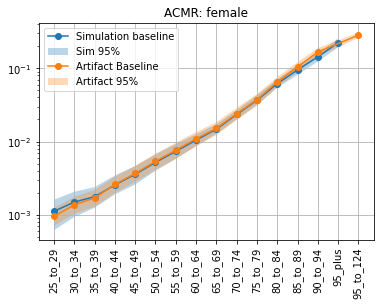

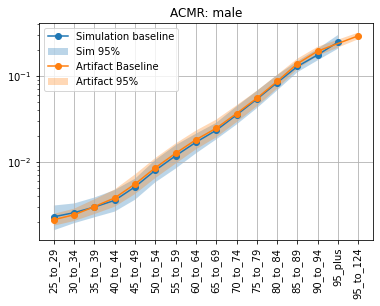

In [58]:
with PdfPages('model1vv_v2_acmr_artifact_and_sim.pdf') as pdf:
    for sex in result_summary_allyears.sex.unique():
        plt.figure() 
        subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_acmr.loc[(art_acmr.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'ACMR: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [59]:
def make_sim_vs_artifact_plots_by_age(sex, year, sim_data, art_data, measure):
    plt.figure(dpi=120) # this dpi makes the figure a little bigger and more clear
    plt.plot(sim_data.loc[(sim_data.sex==sex) & (sim_data.year==year)].age,
            sim_data.loc[(sim_data.sex==sex) & (sim_data.year==year)]['mean'], marker='o')
    plt.plot(art_data.loc[(art_data.sex==sex)].age_group,
            art_data.loc[(art_data.sex==sex)]['mean'], marker='o')
    plt.legend(['Simulation baseline', 'Artifact']) # legend so we know which color is which
    plt.xticks(rotation=90)
    plt.title(f'{measure}: {sex} {year}') # title for ease of review
    plt.grid()
    plt.semilogy()

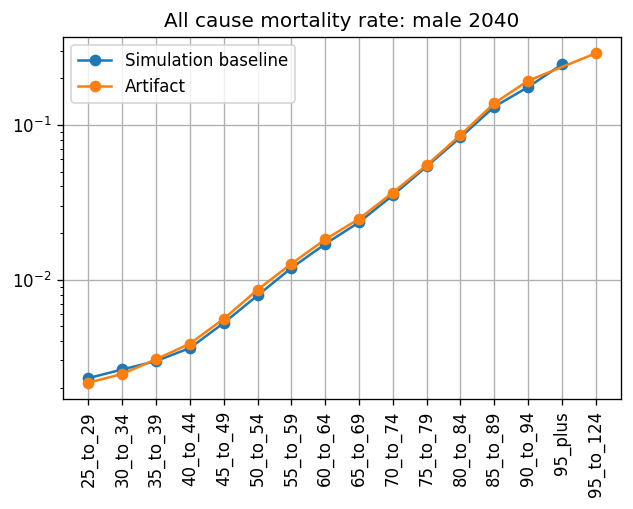

In [60]:
make_sim_vs_artifact_plots_by_age('male', 2040, result_summary, art_acmr, 'All cause mortality rate')

### Cause Specific Mortality Rates

#### Stroke

In [61]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000002,0.000001,0.000003,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000004,0.000002,0.000007,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000006,0.000003,0.000009,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000011,0.000007,0.000016,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000017,0.000011,0.000026,Alabama,cause_specific_mortality_rate,45_to_49


In [62]:
acute_rate_sum_allyear = (acute_rate_2
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [63]:
chronic_rate_allyear = (chronic_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [64]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [65]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000003,0.0,0.000038
1,25_to_29,male,0.000003,0.0,0.000037
2,30_to_34,female,0.000003,0.0,0.000038
3,30_to_34,male,0.000005,0.0,0.000038
4,35_to_39,female,0.000008,0.0,0.000038


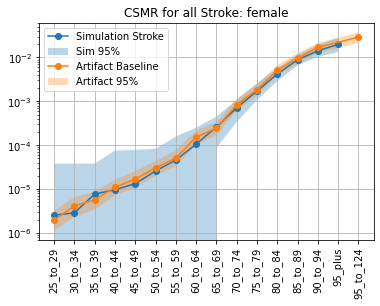

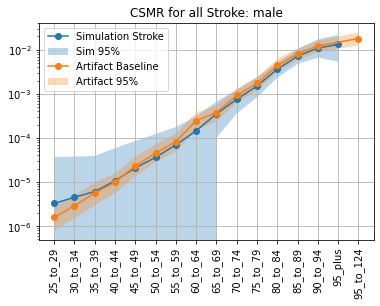

In [66]:
with PdfPages('model1vv_csmr_artifact_and_sim.pdf') as pdf:
    for sex in acute_rate_sum_allyear.sex.unique():
        plt.figure() 
        #subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
        #plt.plot(subdata['age'], subdata['mean'], marker='o')
        #plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        #subdata2 = chronic_rate_allyear.loc[(chronic_rate_allyear.sex==sex)]
        #plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        #plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        subdata4 = total_stroke_rate_allyear.loc[(total_stroke_rate_allyear.sex==sex)]
        plt.plot(subdata4['age'], subdata4['mean'], marker='o')
        plt.fill_between(subdata4['age'], subdata4['2.5%'], subdata4['97.5%'], alpha=.3)
        subdata3 = art_csmr.loc[(art_csmr.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for all Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.yscale('log')
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation Stroke', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Myocardial Infarction

In [67]:
art_csmr2 = load_artifact_data('cause', 'myocardial_infarction', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000017,0.000012,0.000024,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000047,0.000034,0.000064,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000098,0.000072,0.000132,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000232,0.000165,0.000311,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000393,0.000291,0.000513,Alabama,cause_specific_mortality_rate,45_to_49


In [68]:
acute_MI_rate_allyear = (acute_MI_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [69]:
post_MI_rate_allyear = (post_MI_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

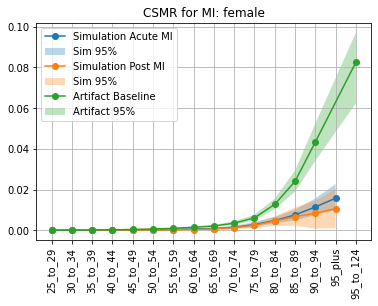

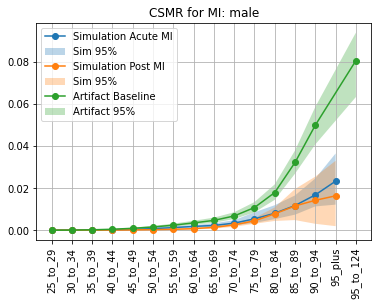

In [70]:
with PdfPages('model1vv_csmr_artifact_and_sim.pdf') as pdf:
    for sex in acute_MI_rate_allyear.sex.unique():
        plt.figure() 
        subdata = acute_MI_rate_allyear.loc[(acute_MI_rate_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = post_MI_rate_allyear.loc[(post_MI_rate_allyear.sex==sex)]
        plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for MI: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        #plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation Acute MI', 'Sim 95%', 'Simulation Post MI', 'Sim 95%','Artifact Baseline', 'Artifact 95%']) 

In [71]:
acute_MI_rate = acute_MI_rate.rename(columns = {'mean_rate':'acute_rate'})
post_MI_rate = post_MI_rate.rename(columns = {'mean_rate':'post_rate'})
total_MI_rate = pd.concat([acute_MI_rate, post_MI_rate.post_rate], axis=1)
total_MI_rate['total_rate'] = total_MI_rate['acute_rate'] + total_MI_rate['post_rate']
total_MI_rate_allyear = (total_MI_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_MI_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000167,0.000038,0.000377
1,25_to_29,male,0.000189,0.000037,0.000383
2,30_to_34,female,0.000162,0.000036,0.000341
3,30_to_34,male,0.000210,0.000037,0.000414
4,35_to_39,female,0.000134,0.000017,0.000293


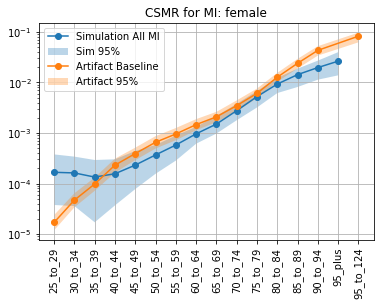

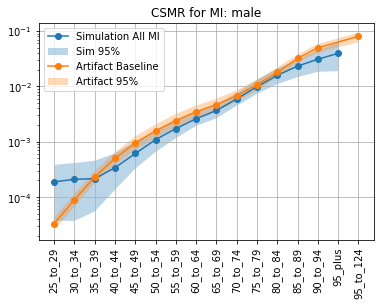

In [72]:
for sex in total_MI_rate_allyear.sex.unique():
    plt.figure() 
    subdata = total_MI_rate_allyear.loc[(total_MI_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for Stroke

In [73]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000116,0.000050,0.000225,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000163,0.000091,0.000266,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000232,0.000128,0.000381,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000370,0.000242,0.000552,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000579,0.000343,0.000939,Alabama,incidence_rate,45_to_49


In [74]:
tran_rate_sum_allyear = (tran_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000168,0.0,0.000649
1,25_to_29,male,0.000128,0.0,0.000524
2,30_to_34,female,0.000198,0.0,0.000612
3,30_to_34,male,0.000208,0.0,0.000815
4,35_to_39,female,0.000229,0.0,0.000706


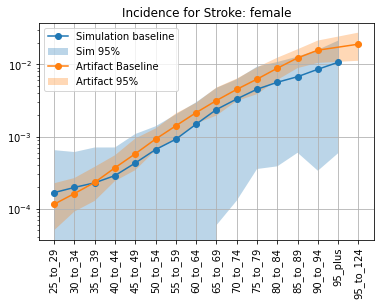

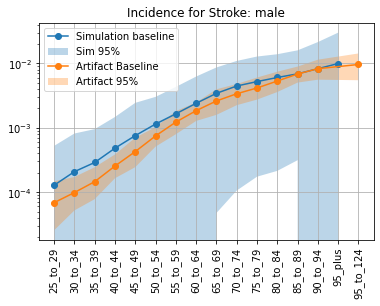

In [75]:
with PdfPages('model1vv_inc_artifact_and_sim.pdf') as pdf:
    for sex in tran_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_inc.loc[(art_inc.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Incidence for Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for MI

In [76]:
art_inc_acute_MI = load_artifact_data('cause', 'myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000452,0.000284,0.000616,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000510,0.000345,0.000683,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000426,0.000296,0.000581,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000540,0.000414,0.000690,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000850,0.000649,0.001110,Alabama,incidence_rate,45_to_49


In [226]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_MI_summ_allyear = (tran_rate_MI_all.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.000474  0.000333  0.000652
         male    0.000450  0.000292  0.000672
30_to_34 female  0.000527  0.000376  0.000749
         male    0.000661  0.000445  0.000886
35_to_39 female  0.000470  0.000380  0.000604

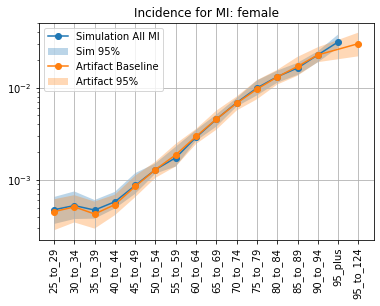

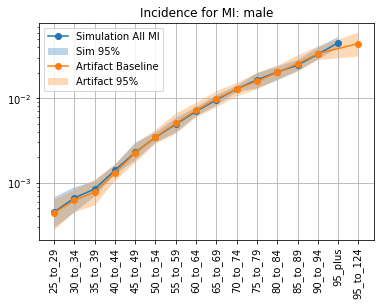

In [227]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_acute_MI.loc[(art_inc_acute_MI.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence Rates

In [81]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [82]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.004986,0.003708,0.006410,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.006119,0.004613,0.007857,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.007737,0.005971,0.010016,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.010115,0.007659,0.013100,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.014078,0.010695,0.018031,Alabama,prevalence,45_to_49


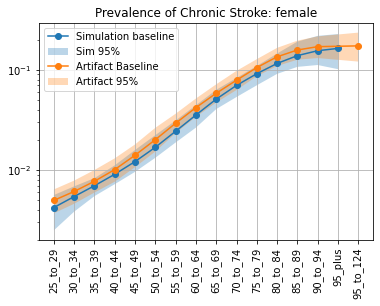

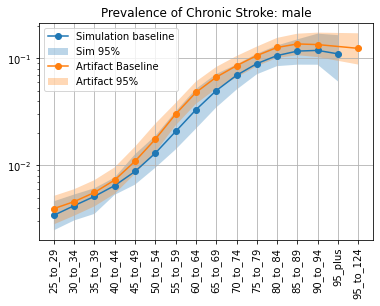

In [83]:
for sex in prev_chronic_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_chronic_rate_sum_allyear.loc[(prev_chronic_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev.loc[(art_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [84]:
prev_acute_rate_sum_allyear = (prev_acute_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [85]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

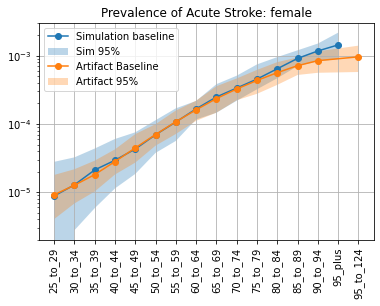

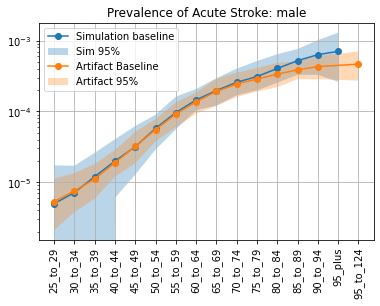

In [86]:
for sex in prev_acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_rate_sum_allyear.loc[(prev_acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev2.loc[(art_prev2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Post MI

In [87]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.001227,0.000904,0.001572,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.002536,0.001865,0.003277,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.004012,0.003125,0.005009,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.005660,0.004450,0.007101,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.007613,0.005996,0.009425,Alabama,prevalence,45_to_49


In [88]:
prev_post_MI_sum_allyear = (prev_post_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.001563,0.001090,0.002220
1,25_to_29,male,0.001205,0.000735,0.001744
2,30_to_34,female,0.003118,0.002179,0.004310
3,30_to_34,male,0.002734,0.001747,0.004247
4,35_to_39,female,0.004649,0.003321,0.006506


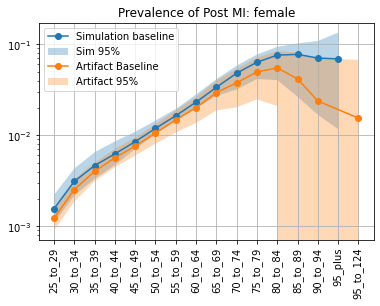

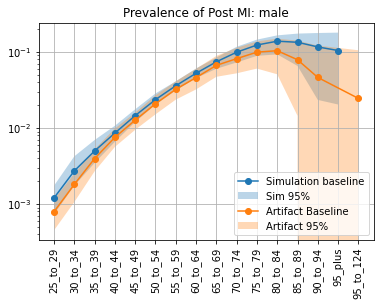

In [89]:
##Can try plotting the median 

for sex in prev_post_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_post_MI_sum_allyear.loc[(prev_post_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev3.loc[(art_prev3.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Acute MI

In [90]:
art_prev4 = load_artifact_data('cause', 'acute_myocardial_infarction', 'prevalence')
art_prev4['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev4.age_start,art_prev4.age_end)]
art_prev4.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000029,0.000019,0.000040,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.000036,0.000024,0.000048,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.000031,0.000022,0.000042,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.000037,0.000028,0.000048,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.000058,0.000044,0.000074,Alabama,prevalence,45_to_49


In [91]:
prev_acute_MI_sum_allyear = (prev_acute_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000036,0.000015,0.000065
1,25_to_29,male,0.000034,0.000012,0.000067
2,30_to_34,female,0.000040,0.000017,0.000071
3,30_to_34,male,0.000050,0.000018,0.000086
4,35_to_39,female,0.000036,0.000017,0.000060


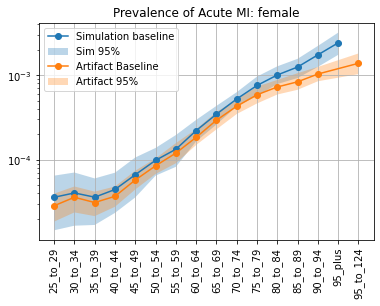

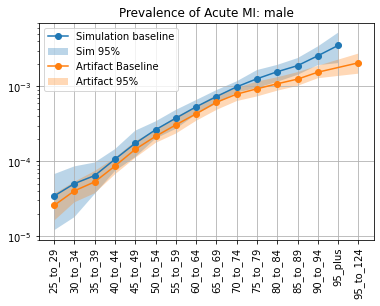

In [92]:
for sex in prev_acute_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_MI_sum_allyear.loc[(prev_acute_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev4.loc[(art_prev4.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Excess Mortality Rate

#### Acute Stroke

In [93]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.309244,0.212204,0.442095,Alabama,excess_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.293380,0.198519,0.416337,Alabama,excess_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.323206,0.234077,0.432974,Alabama,excess_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.322984,0.238528,0.438779,Alabama,excess_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.292713,0.203912,0.393501,Alabama,excess_mortality_rate,45_to_49


In [94]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.228525,0.0,3.261161
1,25_to_29,male,0.769050,0.0,6.522321
2,30_to_34,female,0.164470,0.0,2.608929
3,30_to_34,male,0.480156,0.0,4.348214
4,35_to_39,female,0.332092,0.0,2.819650


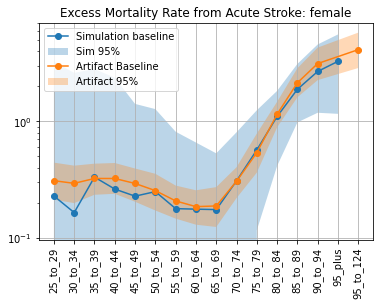

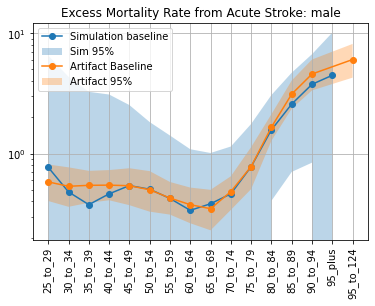

In [95]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr.loc[(art_emr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Chronic Stroke

In [96]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [97]:
chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


chronic_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000000,0.0,0.000000
1,25_to_29,male,0.000000,0.0,0.000000
2,30_to_34,female,0.000030,0.0,0.000000
3,30_to_34,male,0.000097,0.0,0.000000
4,35_to_39,female,0.000142,0.0,0.002333


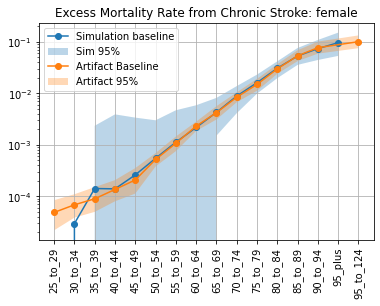

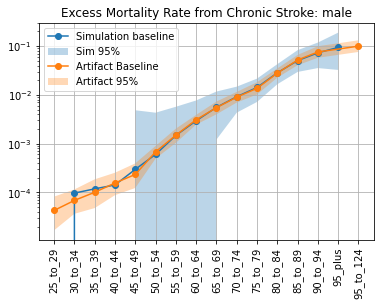

In [98]:
for sex in chronic_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = chronic_rate_emr_allyear.loc[(chronic_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr2.loc[(art_emr2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Acute MI

In [99]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [100]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = pd.concat([acute_MI_emr_rate, acute_MI_EMR.ptvalue], axis=1)
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


acute_MI_emr_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,2.786249,0.0,6.522321
1,25_to_29,male,3.489594,0.0,7.551399
2,30_to_34,female,2.173550,0.0,5.017170
3,30_to_34,male,2.765683,0.0,5.590561
4,35_to_39,female,1.646187,0.0,4.348214


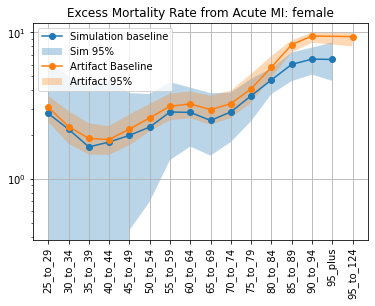

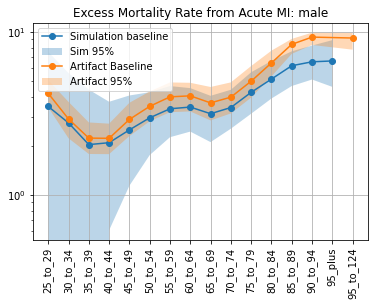

In [101]:
for sex in acute_MI_emr_rate_allyear.sex.unique():
    plt.figure() 
    subdata = acute_MI_emr_rate_allyear.loc[(acute_MI_emr_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_acuteMI.loc[(art_emr_acuteMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Post MI EMR

In [102]:
post_mi_rate_emr_allyear = (post_MI_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.043950,0.0,0.120208
1,25_to_29,male,0.057623,0.0,0.150815
2,30_to_34,female,0.023755,0.0,0.068085
3,30_to_34,male,0.026473,0.0,0.065451
4,35_to_39,female,0.016079,0.0,0.042952


In [103]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

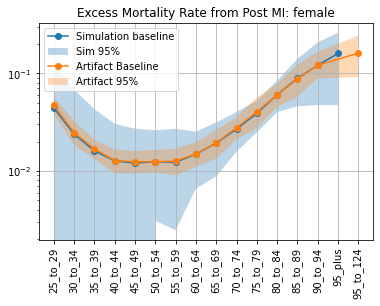

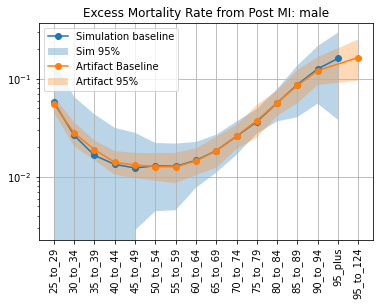

In [104]:
for sex in post_mi_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = post_mi_rate_emr_allyear.loc[(post_mi_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_postMI.loc[(art_emr_postMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### GBD Comparison

#### All Cause Mortality Rate

In [105]:
from db_queries import get_outputs as go
from db_queries import get_ids

In [106]:
gbd_data = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=294, measure_id=1, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [107]:
gbd_data['age'] = gbd_data.age_group_name.str.replace(' ', '_')
gbd_data.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,294,523,1,3,1,2019,_all,25 to 29,All causes,False,Alabama,admin1,Deaths,Rate,Male,0.002153,0.002516,0.001834,25_to_29
1,10,294,523,1,3,2,2019,_all,25 to 29,All causes,False,Alabama,admin1,Deaths,Rate,Female,0.000950,0.001237,0.000706,25_to_29
2,11,294,523,1,3,1,2019,_all,30 to 34,All causes,False,Alabama,admin1,Deaths,Rate,Male,0.002456,0.002887,0.002079,30_to_34
3,11,294,523,1,3,2,2019,_all,30 to 34,All causes,False,Alabama,admin1,Deaths,Rate,Female,0.001364,0.001755,0.001029,30_to_34
4,12,294,523,1,3,1,2019,_all,35 to 39,All causes,False,Alabama,admin1,Deaths,Rate,Male,0.003056,0.003710,0.002501,35_to_39


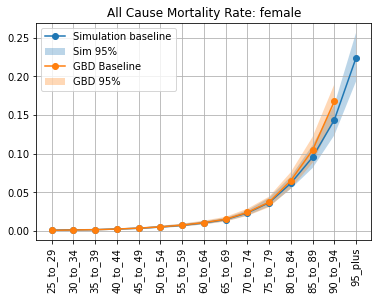

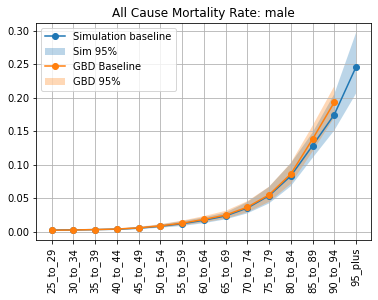

In [108]:
for sex in result_summary_allyears.sex.unique():
    plt.figure() 
    subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_data.loc[(gbd_data.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'All Cause Mortality Rate: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence Rate for Stroke

In [109]:
gbd_incd = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=495, measure_id=6, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [110]:
gbd_incd['age'] = gbd_incd.age_group_name.str.replace(' ', '_')
gbd_incd.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,495,523,6,3,1,2019,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Male,0.000068,0.000147,0.000025,25_to_29
1,10,495,523,6,3,2,2019,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Female,0.000115,0.000224,0.000050,25_to_29
2,11,495,523,6,3,1,2019,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Male,0.000098,0.000171,0.000052,30_to_34
3,11,495,523,6,3,2,2019,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Female,0.000162,0.000265,0.000091,30_to_34
4,12,495,523,6,3,1,2019,cvd_stroke_isch,35 to 39,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Male,0.000145,0.000243,0.000077,35_to_39


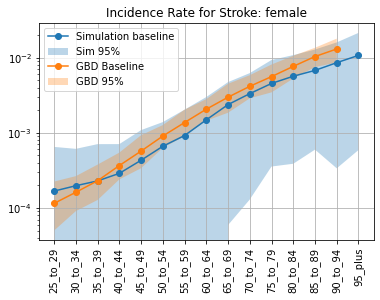

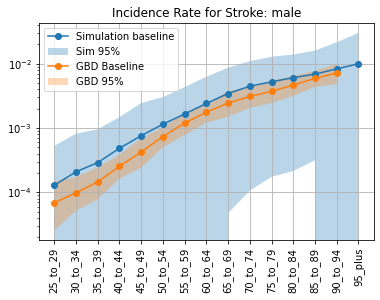

In [111]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd.loc[(gbd_incd.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate for Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence Rate for MI

In [112]:
gbd_incd_MI = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=493, measure_id=6, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')
gbd_incd_MI['age'] = gbd_incd_MI.age_group_name.str.replace(' ', '_')
gbd_incd_MI.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,493,523,6,3,1,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Male,0.000441,0.000626,0.000274,25_to_29
1,10,493,523,6,3,2,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Female,0.000452,0.000616,0.000284,25_to_29
2,11,493,523,6,3,1,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Male,0.000621,0.000818,0.000448,30_to_34
3,11,493,523,6,3,2,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Female,0.000510,0.000683,0.000345,30_to_34
4,12,493,523,6,3,1,2019,cvd_ihd,35 to 39,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Male,0.000777,0.001081,0.000536,35_to_39


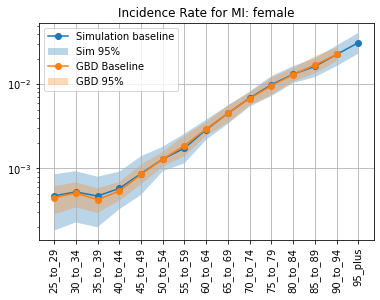

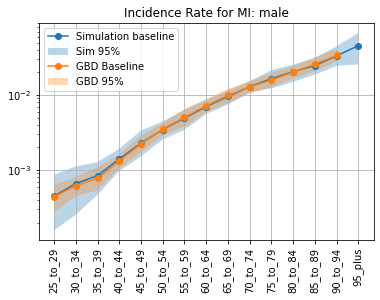

In [113]:
for sex in tran_rate_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_MI_sum_allyear.loc[(tran_rate_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd_MI.loc[(gbd_incd_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence for MI based on all person_time 

In [114]:
tran_rate_MI_GBD = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate_MI_GBD = tran_rate_MI_GBD.loc[(tran_rate_MI_GBD['transition'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction','myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction']))].reset_index()
tran_rate_MI_GBD = tran_rate_MI_GBD.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
tran_rate_MI_GBD = pd.concat([tran_rate_MI_GBD, per_time_group.ptvalue], axis=1)
tran_rate_MI_GBD['rate']= tran_rate_MI_GBD['value'] / tran_rate_MI_GBD['ptvalue']
tran_rate_MI_GBD_summ = (tran_rate_MI_GBD
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_MI_GBD_summ.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000473,0.000183,0.000852
1,25_to_29,male,0.000450,0.000156,0.000863
2,30_to_34,female,0.000527,0.000228,0.000929
3,30_to_34,male,0.000661,0.000255,0.001121
4,35_to_39,female,0.000471,0.000200,0.000799


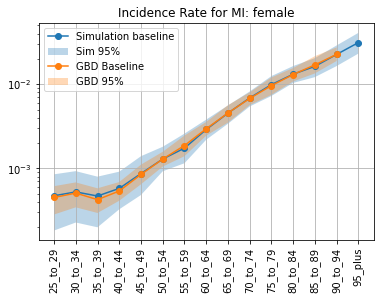

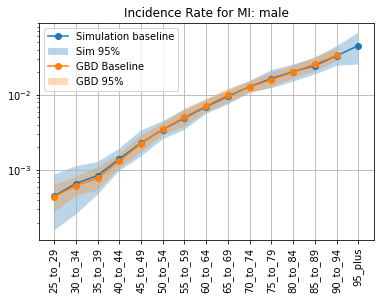

In [115]:
for sex in tran_rate_MI_GBD_summ.sex.unique():
    plt.figure() 
    subdata = tran_rate_MI_GBD_summ.loc[(tran_rate_MI_GBD_summ.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd_MI.loc[(gbd_incd_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### DALYs from Stroke

In [116]:
gbd_daly = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=495, measure_id=2, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [117]:
gbd_daly['age'] = gbd_daly.age_group_name.str.replace(' ', '_')
gbd_daly.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,495,523,2,3,1,2019,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.000573,0.000875,0.000337,25_to_29
1,10,495,523,2,3,2,2019,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.000837,0.001272,0.000515,25_to_29
2,11,495,523,2,3,1,2019,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.000723,0.001057,0.000457,30_to_34
3,11,495,523,2,3,2,2019,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.001110,0.001578,0.000720,30_to_34
4,12,495,523,2,3,1,2019,cvd_stroke_isch,35 to 39,Ischemic stroke,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.000972,0.001417,0.000638,35_to_39


In [118]:
yll_stroke = yll.loc[yll['cause'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke"])].reset_index()
yld_stroke = yld.loc[yld['cause_of_disability'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke"])].reset_index()
len(yll_stroke)

10800

In [119]:
daly_stroke = pd.concat([yll_stroke, yld_stroke.yld], axis=1)
daly_stroke['daly'] = daly_stroke['yll'] + daly_stroke['yld']
daly_stroke.head()

,index,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,yll,yld,daly
0,0,0,female,2023,acute_ischemic_stroke,ylls,29,baseline,25_to_29,0.0,0.000231,0.000231
1,1,1,female,2023,acute_ischemic_stroke,ylls,29,baseline,30_to_34,0.0,0.000292,0.000292
2,2,2,female,2023,acute_ischemic_stroke,ylls,29,baseline,35_to_39,0.0,0.000536,0.000536
3,3,3,female,2023,acute_ischemic_stroke,ylls,29,baseline,40_to_44,0.0,0.000796,0.000796
4,4,4,female,2023,acute_ischemic_stroke,ylls,29,baseline,45_to_49,0.0,0.001253,0.001253


In [120]:
daly_stroke = daly_stroke.groupby(['age', 'sex', 'year', 'input_draw']).daly.sum().reset_index()
daly_stroke_rate = pd.concat([daly_stroke, per_time_group.ptvalue], axis=1)
daly_stroke_rate['daly_rate'] = daly_stroke_rate['daly'] / daly_stroke_rate['ptvalue']
daly_stroke_sum_allyear = (daly_stroke_rate
                .groupby(['age', 'sex'])
                .daly_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_stroke_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000865,8.694257e-10,0.003080
1,25_to_29,male,0.000680,1.653405e-10,0.003176
2,30_to_34,female,0.001082,4.071030e-09,0.003806
3,30_to_34,male,0.000845,1.331403e-09,0.003323
4,35_to_39,female,0.001560,1.138431e-08,0.004556


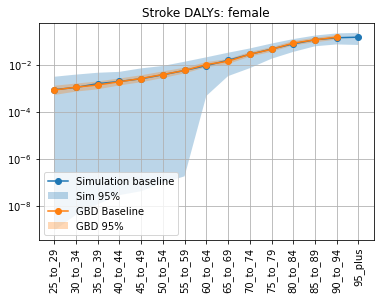

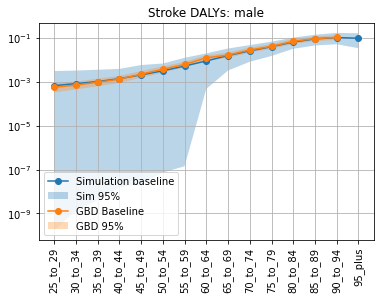

In [121]:
for sex in daly_stroke_sum_allyear.sex.unique():
    plt.figure() 
    subdata = daly_stroke_sum_allyear.loc[(daly_stroke_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_daly.loc[(gbd_daly.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Stroke DALYs: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### DALYs from Acute MI

In [122]:
gbd_daly_MI = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=493, measure_id=2, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [123]:
gbd_daly_MI['age'] = gbd_daly_MI.age_group_name.str.replace(' ', '_')
gbd_daly_MI.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,493,523,2,3,1,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.002084,0.002684,0.001595,25_to_29
1,10,493,523,2,3,2,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.001076,0.001488,0.000753,25_to_29
2,11,493,523,2,3,1,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.005151,0.006505,0.003896,30_to_34
3,11,493,523,2,3,2,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.002720,0.003687,0.001977,30_to_34
4,12,493,523,2,3,1,2019,cvd_ihd,35 to 39,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.012157,0.015460,0.009483,35_to_39


In [124]:
yll_MI = yll.loc[yll['cause'].isin(["acute_myocardial_infarction", "post_myocardial_infarction"])].reset_index()
yll_MI = yll_MI.groupby(['age', 'sex', 'year', 'input_draw']).yll.sum().reset_index()
yld_MI = yld.loc[yld['cause_of_disability'].isin(["acute_myocardial_infarction"])].reset_index()
len(yll_MI)

5400

In [125]:
daly_MI = pd.concat([yll_MI, yld_MI.yld], axis=1)
daly_MI['daly'] = daly_MI['yll'] + daly_MI['yld']
daly_MI.head()

,age,sex,year,input_draw,yll,yld,daly
0,25_to_29,female,2023,29,120.898784,0.131147,121.029931
1,25_to_29,female,2023,232,372.354747,0.087431,372.442179
2,25_to_29,female,2023,357,674.992996,0.113661,675.106657
3,25_to_29,female,2023,394,181.026229,0.131147,181.157377
4,25_to_29,female,2023,602,184.225882,0.271037,184.496920


In [126]:
daly_MI = daly_MI.groupby(['age', 'sex', 'year', 'input_draw']).daly.sum().reset_index()
daly_MI_rate = pd.concat([daly_MI, per_time_group.ptvalue], axis=1)
daly_MI_rate['daly_rate'] = daly_MI_rate['daly'] / daly_MI_rate['ptvalue']
daly_MI_rate_allyear = (daly_MI_rate
                .groupby(['age', 'sex'])
                .daly_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_MI_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.010292,0.002309,0.023236
1,25_to_29,male,0.011645,0.002351,0.023611
2,30_to_34,female,0.009217,0.002057,0.019179
3,30_to_34,male,0.011912,0.002187,0.023426
4,35_to_39,female,0.006967,0.000890,0.015037


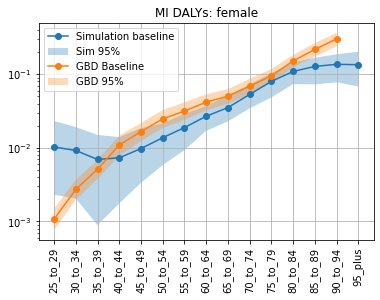

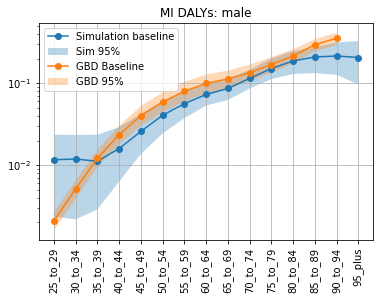

In [127]:
for sex in daly_MI_rate_allyear.sex.unique():
    plt.figure() 
    subdata = daly_MI_rate_allyear.loc[(daly_MI_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_daly_MI.loc[(gbd_daly_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'MI DALYs: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

### LDL-C Testing - Total Exposure by age/year

In [209]:
ldl = pd.read_csv(sim_results_dir + 'ldlc_exposure_time.csv')
ldl.head()

,Unnamed: 0,sex,year,measure,input_draw,scenario,age,value
0,0,female,2023,ldlc_exposure_time,29,baseline,25_to_29,83135.342757
1,1,female,2023,ldlc_exposure_time,29,baseline,30_to_34,79569.913421
2,2,female,2023,ldlc_exposure_time,29,baseline,35_to_39,80284.967429
3,3,female,2023,ldlc_exposure_time,29,baseline,40_to_44,78980.430015
4,4,female,2023,ldlc_exposure_time,29,baseline,45_to_49,79329.507275


In [210]:
ldl_summ = (ldl
                .groupby(['age', 'sex', 'year'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
#ldl_summ

In [222]:
%%capture
for sex in ldl_summ.sex.unique():
    for year in ldl_summ.year.unique():
        plt.figure() 
        subdata = ldl_summ.loc[(ldl_summ.sex==sex) & (ldl_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.ylim(0,100000)
        plt.grid()

In [223]:
%%capture
for sex in ldl_summ.sex.unique():
    for age in ldl_summ.age.unique():
        plt.figure() 
        subdata = ldl_summ.loc[(ldl_summ.sex==sex) & (ldl_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

The absolute number is definitely changing over time. Let's see if this is due to changes in population structure or something else. 

### Rates of Exposure by Age/Year

In [217]:
ldl_rate = ldl.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
ldl_rate = pd.concat([ldl_rate, per_time_group.ptvalue], axis=1)
ldl_rate['ldl_rate'] = ldl_rate['value'] / ldl_rate['ptvalue']
ldl_rate_summ = (ldl_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,2.811427,2.581322,3.078110
1,25_to_29,female,2024,2.811156,2.579970,3.076567
2,25_to_29,female,2025,2.811291,2.580404,3.075281
3,25_to_29,female,2026,2.810785,2.578454,3.075657
4,25_to_29,female,2027,2.811180,2.580116,3.080090


In [216]:
## Want to think through these. These are now rates - why is it dropping at older age groups? Selection bias 
## (those with high cholestrol don't live as long?) Something else? 

%%capture
for sex in ldl_rate_summ.sex.unique():
    for year in ldl_rate_summ.year.unique():
        plt.figure() 
        subdata = ldl_rate_summ.loc[(ldl_rate_summ.sex==sex) & (ldl_rate_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {year}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

UsageError: Line magic function `%%capture` not found.


In [219]:
## These look a bit funny - we should discuss. What is causing changes over time across these groups? 
## Why is this not 3? 

%%capture
for sex in ldl_rate_summ.sex.unique():
    for age in ldl_rate_summ.age.unique():
        plt.figure() 
        subdata = ldl_rate_summ.loc[(ldl_rate_summ.sex==sex) & (ldl_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

UsageError: Line magic function `%%capture` not found.


### Within 2023, LDL-C Distribution 

In [172]:
ldl_2023 = ldl.loc[ldl['year']==2023].reset_index()
ldl_2023.head()

,index,Unnamed: 0,sex,year,measure,input_draw,scenario,age,value
0,0,0,female,2023,ldlc_exposure_time,29,baseline,25_to_29,83135.342757
1,1,1,female,2023,ldlc_exposure_time,29,baseline,30_to_34,79569.913421
2,2,2,female,2023,ldlc_exposure_time,29,baseline,35_to_39,80284.967429
3,3,3,female,2023,ldlc_exposure_time,29,baseline,40_to_44,78980.430015
4,4,4,female,2023,ldlc_exposure_time,29,baseline,45_to_49,79329.507275


### Compare with Artifact 
'risk_factor.high_ldl_cholesterol.distribution' - just says "ensemble"

'risk_factor.high_ldl_cholesterol.exposure'

'risk_factor.high_ldl_cholesterol.exposure_standard_deviation'

'risk_factor.high_ldl_cholesterol.exposure_distribution_weights'- weights of the ensemble dist

'risk_factor.high_ldl_cholesterol.relative_risk'

'risk_factor.high_ldl_cholesterol.population_attributable_fraction'

'risk_factor.high_ldl_cholesterol.tmred' - GBD values, no testing

'risk_factor.high_ldl_cholesterol.relative_risk_scalar' - this is just 1

In [220]:
ldl_exp = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_exp['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_exp.age_start,ldl_exp.age_end)]
ldl_exp.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,2.805110,2.597516,3.051877,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,2.790157,2.588387,2.991761,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,2.855153,2.640309,3.069596,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,2.864634,2.652549,3.073091,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,2.994765,2.785903,3.219201,Alabama,exposure,45_to_49


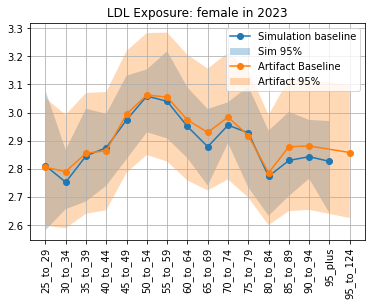

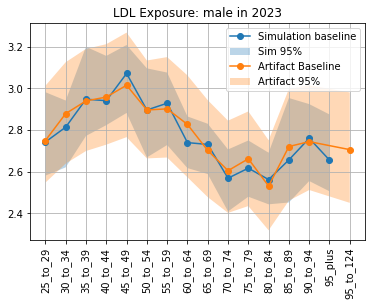

In [221]:
for sex in ldl_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_rate_summ.loc[(ldl_rate_summ.sex==sex) & (ldl_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_exp.loc[(ldl_exp.sex==sex) & (ldl_exp.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 